In [1]:
import sys
import os
base_path = os.getcwd()
sys.path.insert(0, os.path.join(base_path, '..', '..','..')) # location of src

from ecog.decoder.feature_transformation import *

import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
lp = os.path.join(base_path, '..', '..',
                  'data', 'preprocessed_data', 'cikk',
                  'HTNet_data_03.hdf5')

if os.path.isfile(lp):  # if raw data exist, load it ( otherwise use presaved weights (if exist))
    preprocessed_data = h5py.File(lp, 'r')

    train_x = preprocessed_data['train_x']
    train_y = preprocessed_data['train_y']
    test_x = preprocessed_data['test_x']
    test_y = preprocessed_data['test_y']



pat_ids = {
    'EC01':'a0f66459',
    'EC02':'c95c1e82',
    'EC03':'cb46fd46',
    'EC04':'fcb01f7a',
    'EC05':'ffb52f92',
    'EC06':'b4ac1726',
    'EC07':'f3b79359',
    'EC08':'ec761078',
    'EC09':'f0bbc9a9',
    'EC10':'abdb496b',
    'EC11':'ec168864',
    'EC12':'b45e3f7b'
}

subjects=list(pat_ids.keys())
    # subjects = ['EC07']

lfb = range(7,15)
hfb = range(76,101)

rest_label = 1
move_lavel = 2

In [3]:
'''def custom_plot(data, title):
    fig = plt.figure(figsize=(5,3.5))
    #fig.patch.set_facecolor('white')
    plt.imshow(data)

    ax = plt.gca()

    # Major ticks
    ax.set_xticks(np.arange(0, 8, 1))
    ax.set_yticks(np.arange(0, 8, 1))

    # Labels for major ticks
    ax.set_xticklabels(np.arange(1, 8+1, 1))
    ax.set_yticklabels(np.arange(1, 8+1, 1))

    # Minor ticks
    ax.set_xticks(np.arange(.5, 8, 1), minor=True)
    ax.set_yticks(np.arange(.5, 8, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='silver', linestyle='--', linewidth=1)
    plt.title(title)
    plt.colorbar()
    plt.show()
'''

"def custom_plot(data, title):\n    fig = plt.figure(figsize=(5,3.5))\n    #fig.patch.set_facecolor('white')\n    plt.imshow(data)\n\n    ax = plt.gca()\n\n    # Major ticks\n    ax.set_xticks(np.arange(0, 8, 1))\n    ax.set_yticks(np.arange(0, 8, 1))\n\n    # Labels for major ticks\n    ax.set_xticklabels(np.arange(1, 8+1, 1))\n    ax.set_yticklabels(np.arange(1, 8+1, 1))\n\n    # Minor ticks\n    ax.set_xticks(np.arange(.5, 8, 1), minor=True)\n    ax.set_yticks(np.arange(.5, 8, 1), minor=True)\n\n    # Gridlines based on minor ticks\n    ax.grid(which='minor', color='silver', linestyle='--', linewidth=1)\n    plt.title(title)\n    plt.colorbar()\n    plt.show()\n"

/opt/miniconda3/envs/ecog/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/opt/miniconda3/envs/ecog/lib/python3.8/site-packages/nilearn/plotting/displays.py:666: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure(figure, figsize=figsize,


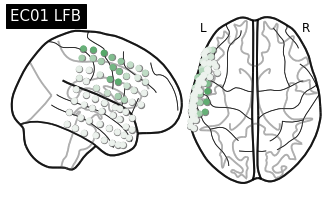

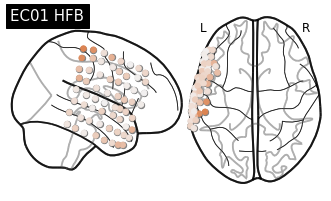

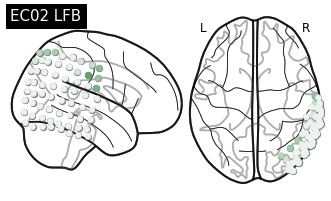

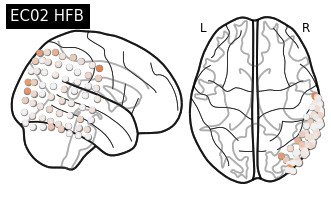

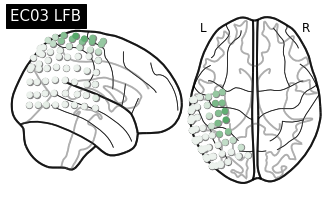

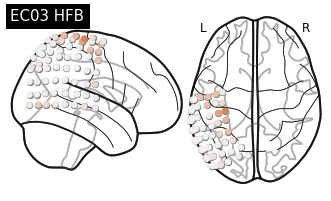

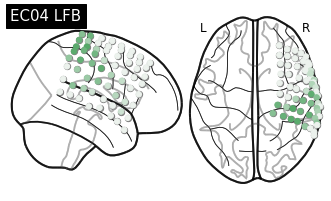

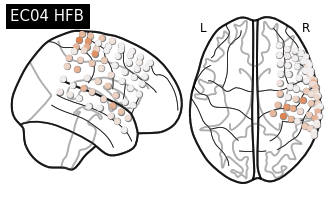

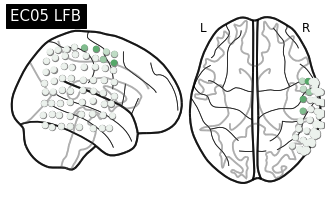

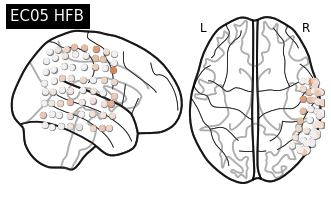

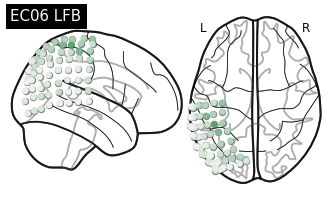

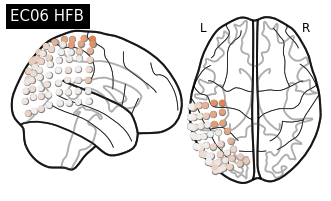

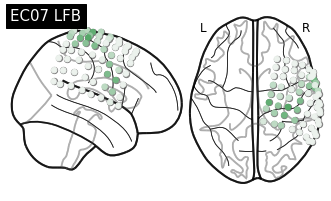

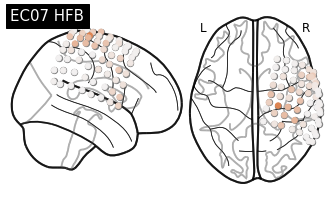

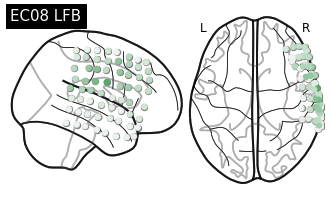

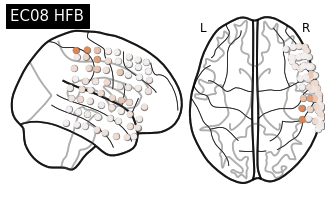

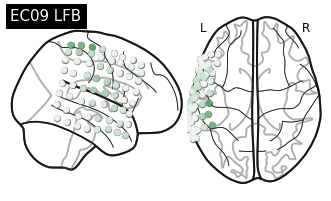

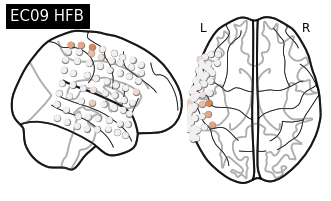

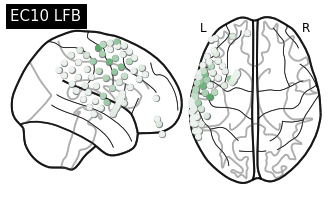

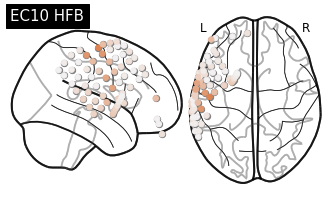

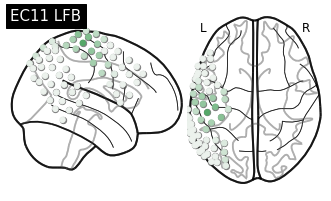

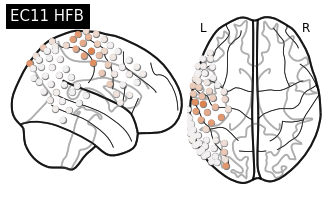

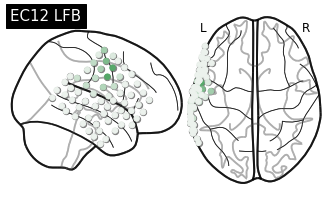

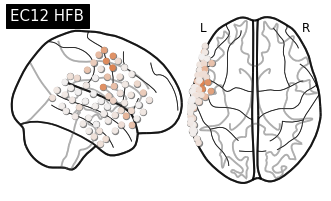

In [4]:
import pandas as pd
import nilearn.plotting as nl

for i, name in enumerate(subjects):
#for i, name in enumerate(['EC01']):

    # calaulate r_lfb and r_hfb values if the data is found (i.e if the raw recording is downloaded), else load the pre calculated results
    if os.path.isfile(lp):
        px = np.asarray(train_x[name])
        px = np.transpose(px, axes=[2,1,0])
        py = np.asarray(train_y[name])
        print('(feature vector shape) (label vector shape): ', px.shape, py.shape)
        print('unique labels: ', np.unique(py), '\n')

        ## Normalize data & isolate HFB and LFB

        num_chans = px.shape[1]
        num_trials = px.shape[2]

        px_mean = np.mean(px, axis=2)

        ## Isolate HFB and LFB,

        px_temp = np.divide(px, np.dstack([px_mean]*num_trials))  # normalize data:every datapoint is divided by the average power of the same freq at the same channel
        lfb_trials = squeeze(sum(px_temp[lfb,:,:],0))
        hfb_trials = squeeze(sum(px_temp[hfb,:,:],0))

        ## Comparisons - signed r-squared and unpaired t-test
        #hand=hand v rest, tongue=tongue v rest; r = signed square cross correlation, p=p-value from paired t-test

        r_LFB = []; r_HFB = []
        p_LFB = []; p_HFB = []

        for ch in range(num_chans):
            # extract rest data
            LFB_m1 = lfb_trials[ch, np.where(py == 1)]
            HFB_m1 = hfb_trials[ch, np.where(py == 1)]

            # extract move data
            LFB_1 = lfb_trials[ch, np.where(py == 2)]
            HFB_1 = hfb_trials[ch, np.where(py == 2)]

            # calculate r-squared cross correlation
            r_LFB.append(rsa(LFB_1, LFB_m1))
            r_HFB.append(rsa(HFB_1, HFB_m1))

            # calculate p-value of t-test
            p_LFB.append(float(ttest_ind(LFB_1, LFB_m1, 1)[1]))
            p_HFB.append(float(ttest_ind(HFB_1, HFB_m1, 1)[1]))

        # 'we included only electrodes with changes in power significant at the 0.05 Bonferroni-corrected level'
        r_LFB = np.where(np.asarray(p_LFB)<0.05 , r_LFB, 0)
        r_HFB = np.where(np.asarray(p_HFB)<0.05 , r_HFB, 0)

        if not os.path.exists('suppl_data'):
            os.makedirs('suppl_data')
        np.save(os.path.join('suppl_data', 'r_LFB_{}.npy'.format(name)), r_LFB)
        np.save(os.path.join('suppl_data', 'r_HFB_{}.npy'.format(name)), r_HFB)
    else:
        r_LFB = np.load(os.path.join('suppl_data', 'r_LFB_{}.npy'.format(name)))
        r_HFB = np.load(os.path.join('suppl_data', 'r_HFB_{}.npy'.format(name)))

    # plot correlation
    '''fig = plt.figure(figsize=[20,4])
    ax = fig.gca()
    ax.set_xticks(np.arange(0, len(r_LFB), 1))
    ax.plot(r_LFB, label='LFB', color='g')
    ax.plot(r_HFB,label='HFB', color='orange')
    ax.plot(p_LFB, label='LFB p-value', color='g', linestyle='dotted')
    ax.plot(p_HFB,label='HFB p-value', color='orange', linestyle='dotted')
    plt.grid()!data/raw_data/naturalistic_move_v_rest/electrode_locations/*

    plt.legend()
    plt.title('correlation')
    plt.show()

    r_LFB_temp = np.asarray(r_LFB[:64]).reshape(8, 8)
    r_HFB_temp = np.asarray(r_HFB[:64]).reshape(8, 8)

    custom_plot(np.abs(r_LFB_temp), 'Low Frequency Band')
    custom_plot(r_HFB_temp, 'High Frequency Band')'''

    # plot on brain
    file = os.path.join(base_path, '..', '..',
                        'data','raw_data', 'naturalistic_move_v_rest',
                        'electrode_locations',
                        'ecog_metadata_{}.csv'.format(pat_ids[name]))
    df = pd.read_csv(file)
    ch_names = df['Unnamed: 0'].values.tolist()
    elec = np.asarray([[x,y,z] for x,y,z in zip(df['X'], df['Y'], df['Z'])])
    elec = elec[:64,:]

    #weights = [-1*x for x in r_LFB]
    weights_lfb = [x for x in r_LFB]
    weights_hfb = [x for x in r_HFB]
    w_range = [abs(min(weights_lfb)), abs(max(weights_hfb))]
    w_bound = max(w_range)
    #norm = np.linalg.norm(weights)
    #weights_norm = weights/norm
    #color = [[w, 0, 0, 1] for w in weights]

    nl.plot_connectome(adjacency_matrix=np.eye(elec.shape[0]),
                       node_coords=elec,
                       node_size=40,
                       alpha=.4,
                       display_mode='xz',
                       node_color='grey',
                       figure=2*i,
                       )

    savedir_lfb = os.path.join(base_path, '..', '..',
                                             'analysis', 'move_vs_rest',
                                             'figs', 'correlation',
                                             'LFB_{}.png'.format(name))

    nl.plot_markers(#adjacency_matrix=np.eye(elec.shape[0]),
                    node_coords=elec,
                    node_values=weights_lfb[:64],
                    node_size=30,
                    display_mode='xz',
                    alpha=1,
                    node_cmap=sns.light_palette(sns.color_palette('deep')[2],
                                                n_colors=20,
                                                reverse=True, as_cmap=True,
                                                input='rgb'),
                    #node_vmin= -1*w_bound,
                    node_vmax=0,
                    #output_file=savedir_lfb,
                    title=name +' LFB',
                    figure=2*i,
                    colorbar=False,
        )

    nl.plot_connectome(adjacency_matrix=np.eye(elec.shape[0]),
                       node_coords=elec,
                       node_size=40,
                       alpha=1,
                       display_mode='xz',
                       node_color='grey',
                       figure=2*i+1,
                       )

    savedir_hfb = os.path.join(base_path, '..', '..',
                                         'analysis', 'move_vs_rest',
                                         'figs', 'correlation',
                                         'LFB_{}.png'.format(name))

    nl.plot_markers(#adjacency_matrix=np.eye(elec.shape[0]),
                    node_coords=elec,
                    node_values=weights_hfb[:64],
                    node_size=30,
                    display_mode='xz',
                    alpha=1,
                    node_cmap=sns.light_palette(sns.color_palette('deep')[1],
                                                n_colors=20,
                                                reverse=False, as_cmap=True,
                                                input='rgb'),
                    figure=2*i+1,
                    node_vmin=0,
                    title=name +' HFB',
                    colorbar=False,
                    #output_file=savedir_hfb
                    #colorbar=True)
    )

    '''nl.plot_connectome(adjacency_matrix=np.eye(elec.shape[0]),
                       node_coords=elec,
                       node_color=weights[:64],
                       title=name + ' HFB')'''
